In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [125]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.1


In [126]:
df = pd.read_csv('HealthData.csv') 
print("Data Shape:", df.shape) 
print(df.tail()) 

Data Shape: (10000, 4)
              0    1          2   3
9995  94.351250  120  85.640170  78
9996  94.332858  105  89.476571  78
9997  94.019118  101  86.060694  74
9998  94.539050  115  89.969613  73
9999  94.999523  101  88.229969  73


In [127]:
df.describe()

,0,1,2,3
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,97.740490,91.42520,95.243587,82.991400
std,2.182264,17.50997,3.984716,7.832807
min,94.000464,60.00000,85.003689,70.000000
25%,95.998633,76.00000,92.046497,77.000000
50%,98.077522,94.00000,96.738618,82.000000
75%,99.121507,106.00000,98.726657,89.000000
max,102.497957,120.00000,99.999741,100.000000


In [128]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [129]:
print(train_dataset.head())
print(test_dataset.head())

              0    1          2    3
9394  94.869347  105  89.481285   80
898   98.630365   87  98.793590  100
2398  96.518745   93  95.372640   80
5906  97.090167   70  97.955305   75
2343  99.371031  100  98.343972   86
            0   1          2   3
0   98.188214  80  99.749348  90
13  98.446209  76  99.995132  91
21  98.986769  88  98.603799  96
25  98.373404  74  98.903565  97
26  98.562239  86  99.639296  96


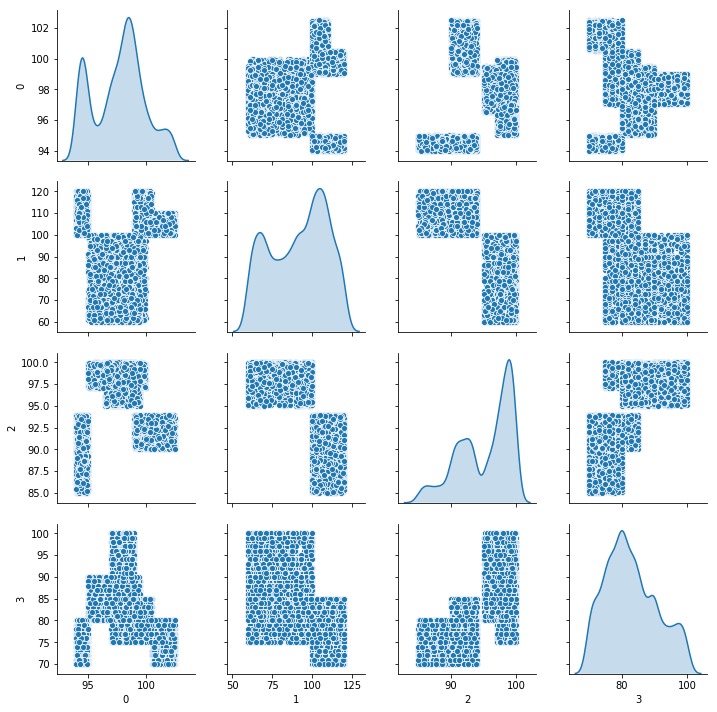

In [130]:
sns.pairplot(train_dataset[['0', '1', '2', '3']], diag_kind='kde')

In [131]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('3')
test_labels = test_features.pop('3')
print(train_features.head())
print(test_features.head())

              0    1          2
9394  94.869347  105  89.481285
898   98.630365   87  98.793590
2398  96.518745   93  95.372640
5906  97.090167   70  97.955305
2343  99.371031  100  98.343972
            0   1          2
0   98.188214  80  99.749348
13  98.446209  76  99.995132
21  98.986769  88  98.603799
25  98.373404  74  98.903565
26  98.562239  86  99.639296


In [132]:
train_stats = train_dataset.describe()
train_stats.pop('3')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
0,8000.0,97.737342,2.189497,94.000464,95.975504,98.069006,99.115547,102.497160
1,8000.0,91.504875,17.470600,60.000000,76.000000,94.000000,106.000000,120.000000
2,8000.0,95.258649,3.982696,85.003689,92.062597,96.782997,98.744269,99.999741


In [166]:
def norm(x):
    return (x - train_stats['mean'])/train_stats['std']

norm_trained_data = norm(train_features)
norm_test_data = norm(test_features)

In [167]:
print(norm_trained_data.head())
print(norm_test_data.head())

             0         1         2
9394 -1.309888  0.772448 -1.450617
898   0.407867 -0.257855  0.887575
2398 -0.556565  0.085579  0.028621
5906 -0.295581 -1.230918  0.677093
2343  0.746148  0.486253  0.774682
           0         1         2
0   0.205925 -0.658528  1.127552
13  0.323758 -0.887484  1.189265
21  0.570646 -0.200616  0.839921
25  0.290506 -1.001962  0.915188
26  0.376752 -0.315094  1.099920


In [168]:
def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation=tf.nn.tanh, input_shape=[len(train_features.keys())]),
        layers.Dense(32, activation=tf.nn.tanh),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.01)
    
    model.compile(loss="mse", optimizer = optimizer, metrics=['mse', 'mae'])
    return model

In [169]:
model = build_model()

In [170]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


In [171]:
example_batch = norm_trained_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.191],
       [-0.213],
       [-0.14 ],
       [-0.247],
       [-0.064],
       [-0.   ],
       [-0.214],
       [ 0.35 ],
       [-0.048],
       [-0.26 ]], dtype=float32)

In [172]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(norm_trained_data, train_labels, 
                    epochs=1000, validation_split=0.2, verbose=1, callbacks=[early_stop])

Epoch 1/1000
200/200 [==============================] - 0s 2ms/step - loss: 2162.7244 - mse: 2162.7244 - mae: 41.8151 - val_loss: 196.3753 - val_mse: 196.3753 - val_mae: 11.6949
Epoch 2/1000
200/200 [==============================] - 0s 2ms/step - loss: 53.3943 - mse: 53.3943 - mae: 5.6578 - val_loss: 29.6418 - val_mse: 29.6418 - val_mae: 4.4606
Epoch 3/1000
200/200 [==============================] - 0s 1ms/step - loss: 30.3478 - mse: 30.3478 - mae: 4.4783 - val_loss: 28.0577 - val_mse: 28.0577 - val_mae: 4.2779
Epoch 4/1000
200/200 [==============================] - 0s 1ms/step - loss: 26.4186 - mse: 26.4186 - mae: 4.1153 - val_loss: 23.6919 - val_mse: 23.6919 - val_mae: 3.8618
Epoch 5/1000
200/200 [==============================] - 0s 1ms/step - loss: 24.3369 - mse: 24.3369 - mae: 3.9150 - val_loss: 22.8615 - val_mse: 22.8615 - val_mae: 3.7800
Epoch 6/1000
200/200 [==============================] - 0s 1ms/step - loss: 23.8597 - mse: 23.8597 - mae: 3.8657 - val_loss: 23.0470 - val_mse

In [173]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mse,mae,val_loss,val_mse,val_mae,epoch
0,2162.724365,2162.724365,41.815147,196.375305,196.375305,11.694921,0
1,53.394283,53.394283,5.657756,29.641792,29.641792,4.460623,1
2,30.347807,30.347807,4.478272,28.057690,28.057690,4.277922,2
3,26.418591,26.418591,4.115261,23.691872,23.691872,3.861759,3
4,24.336903,24.336903,3.914958,22.861547,22.861547,3.779989,4


In [185]:
def plot_loss(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.legend()
    plt.ylim([3,5])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.legend()
    plt.ylim([20,30])

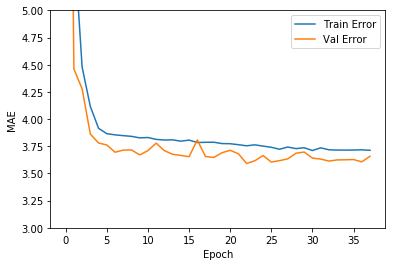

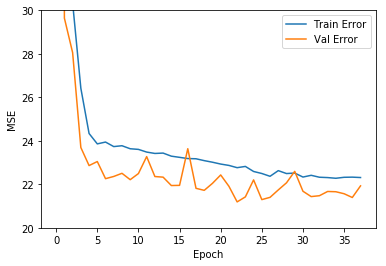

In [186]:
plot_loss(history)

In [187]:
# model = build_model()

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# history = model.fit(norm_trained_data, train_labels, 
#                     epochs=1000, validation_split=0.2, verbose=1, callbacks=[early_stop])

In [188]:
# plot_loss(history)

In [189]:
loss, mse, mae = model.evaluate(norm_test_data, test_labels, verbose=1)
print(mae)

63/63 [==============================] - 0s 2ms/step - loss: 22.2514 - mse: 22.2514 - mae: 3.7183
3.718329429626465


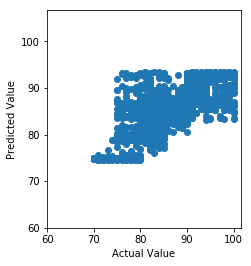

In [191]:
test_predictions = model.predict(norm_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.axis('equal')
plt.axis('square')
plt.xlim(60, plt.xlim()[1])
plt.ylim(60, plt.ylim()[1])

_ = plt.plot()

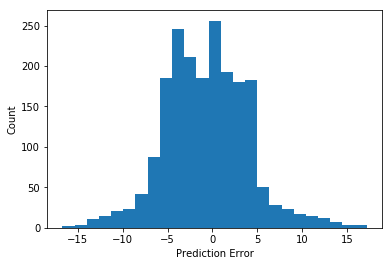

In [192]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [179]:
# model_name = 'Model_v1.h5'
# keras.models.save_model(model, model_name)

In [180]:
# # Convert the model
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('model_v1.tflite', 'wb') as f:
#   f.write(tflite_model)

In [213]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, './JSONmodel')

C:\ProgramData\Anaconda3\lib\site-packages\tensorflowjs\converters\keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
